# Лабораторная работа №2
## Курс "Системы очувствления роботов"

Необходимо реализовать расширенный фильтр калмана (линеаризованный).

Задача: найти положение в 1D пространстве, только в отличии от предыдущего примера (где измеряли изменение положения по данным GPS) используем данные с камеры, измеряя высоту отдаленных ориентиров относительно горизонта.<br />
Важно!
1.) Сохраним ту же модель линейного движения, что и в исходном
примере, и предположим, что мы знаем высоту ориентира и его положение в глобальной системе координат.
2.) Поскольку наш датчик измеряет угол, наша измерительная модель имеет нелинейную зависимость от положения
движущегося объекта.

<img src="https://likerobotics.ru/images/task2.jpg" width="400"/>

### Исходные данные 
Состояние
$$
\mathbf{x}=\left[\begin{array}{c}
p \\
\frac{d p}{d t}=\dot{p}
\end{array}\right]
$$
вход управления  $\quad \mathbf{u}=a=\frac{d^{2} p}{d t^{2}}$
<br />

Модель движения
$$
\begin{aligned}
\mathbf{x}_{k} &=\mathbf{f}\left(\mathbf{x}_{k-1}, \mathbf{u}_{k-1}, \mathbf{w}_{k-1}\right) \\
&=\left[\begin{array}{cc}
1 & \Delta t \\
0 & 1
\end{array}\right] \mathbf{x}_{k-1}+\left[\begin{array}{c}
0 \\
\Delta t
\end{array}\right] \mathbf{u}_{k-1}+\mathbf{w}_{k-1} \\
v_{k} & \sim \mathscr{N}(0,0.01) \quad \mathbf{w}_{k} \sim \mathscr{N}\left(\mathbf{0},(0.1) \mathbf{1}_{2 \times 2}\right)
\end{aligned}
$$

Модель измерения
$$
\begin{aligned}
y_{k} &=\phi_{k}=h\left(p_{k}, v_{k}\right) \\
&=\tan ^{-1}\left(\frac{S}{D-p_{k}}\right)+v_{k}
\end{aligned}
$$

Якобиан модели движения
$$
\begin{array}{l}
\mathbf{F}_{k-1}=\left.\frac{\partial \mathbf{f}}{\partial \mathbf{x}_{k-1}}\right|_{\hat{\mathbf{x}}_{k-1}, \mathbf{u}_{k-1}, \mathbf{0}}=\left[\begin{array}{cc}
1 & \Delta t \\
0 & 1
\end{array}\right] \\
\mathbf{L}_{k-1}=\left.\frac{\partial \mathbf{f}}{\partial \mathbf{w}_{k-1}}\right|_{\hat{\mathbf{x}}_{k-1, \mathbf{u}_{k-1}, \mathbf{0}}}=\mathbf{1}_{2 \times 2}
\end{array}
$$

Якобиан модели измерения
$$
\begin{array}{l}
\mathbf{H}_{k}=\left.\frac{\partial h}{\partial \mathbf{x}_{k}}\right|_{\check{x}_{k}, \mathbf{0}}=\left[\begin{array}{ll}
\frac{S}{\left(D-\check{p}_{k}\right)^{2}+S^{2}} & 0
\end{array}\right] \\
M_{k}=\left.\frac{\partial h}{\partial v_{k}}\right|_{\check{x}_{k}, \mathbf{0}}=1
\end{array}
$$

Необходимо найти положение объекта в момент
времени 𝒌 + 𝟏, при ∆𝒕 = 𝟎. 𝟓 сек

$$
\begin{array}{cl}
\hat{\mathbf{x}}_{0} \sim \mathscr{N}\left(\left[\begin{array}{l}
0 \\
5
\end{array}\right],\right. & \left.\left[\begin{array}{cc}
0.01 & 0 \\
0 & 1
\end{array}\right]\right) \\
u_{0}=-2\left[\mathrm{~м} / \mathrm{с}^{2}\right] & y_{1}=\pi / 6[\mathrm{рад.}] \\
S=20[\mathrm{~м}] & D=40[\mathrm{~м}]
\end{array}
$$

In [88]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
import math

Змечание: мы линеризуем модель движения относительно предыдущей оценки, а модель измерения линеаризуем относительно предсказанного состояния.

In [89]:
x_0 = np.array([[0],[5]])
P_0 = np.array([[0.01 , 0],
                [0, 1]]) #ковариация в моментв ремени 0
w_k = np.array([[0.1 , 0],
                [0, 0.1]]) #ковариация модели движения в момент времени 0 (матрица Q в формулах)

v_k = np.array([0.05]).reshape((1,1)) #ковариация модели измерения в момент времени 0 (в формулах R)
u_0 = -2
y_1 = math.pi / 6
dt = 0.5
S = 20
D = 40
M_k = np.array([[1]])
R_k = np.array([[0.01]])

Необходимо теперь получить предсказания для x_k и P_k

In [90]:
f_matrix = np.array([[1, dt], [0, 1]])
g_matrix = np.array([[0], [dt]])
x_k = f_matrix.dot(x_0) + g_matrix*u_0

# пересчет ковариационной матрицы
P_k = f_matrix@P_0@f_matrix.T + w_k
P_k

array([[0.36, 0.5 ],
       [0.5 , 1.1 ]])

### Модель измерения уже другая!!!
Далее необходимо внести правки

In [91]:
# теперь надо сделать коррекцию

H =  np.array([[S/((D - x_k[0].item())**2 + S**2), 0]])
K_k = P_k@H.T@inv(H@P_k@H.T + M_k*R_k*M_k.T)
K_k

array([[0.39686426],
       [0.55120036]])

In [92]:
h = math.atan((S / (D - x_k[0].item()))) 
h

0.4899573262537283

In [93]:
# осталось выполнить поправку оценки состояния и ковариационной матрицы
x_state =  x_k + K_k*(y_1 - h)
P_state = (np.eye(P_k.shape[0]) - K_k*H) @ P_k
print(x_state)
print(P_state)

[[2.51335109]
 [4.01854318]]
[[0.35841804 0.49780283]
 [0.49780283 1.09694837]]


## Фильтрация для интервала от 0 до 20 сек с интервалом измерений 0,1 сек
Для самостоятельного выполнения

In [94]:
y_k = np.array([0.46364761, 0.46394331, 0.45583792, 0.4602238 , 0.46756375,
       0.4591102 , 0.47721062, 0.46612852, 0.4686494 , 0.46785832,
       0.47167686, 0.47346588, 0.46724847, 0.46946143, 0.48393537,
       0.49785568, 0.49436255, 0.47591332, 0.49836541, 0.47975576,
       0.46921458, 0.49445381, 0.49922302, 0.49645678, 0.49357358,
       0.501212  , 0.49515677, 0.50119725, 0.48464343, 0.50344966,
       0.49899733, 0.51208231, 0.50237515, 0.49932464, 0.49032495,
       0.50360651, 0.50900636, 0.49826695, 0.51304355, 0.51059352,
       0.49593827, 0.49665214, 0.49291056, 0.50055505, 0.48112357,
       0.47786448, 0.4851439 , 0.49323178, 0.47000781, 0.49015249,
       0.46713393, 0.46538848, 0.47627175, 0.48876572, 0.46216271,
       0.464675  , 0.46566391, 0.48231029, 0.46755605, 0.45045919,
       0.44866864, 0.45022331, 0.45520167, 0.46130849, 0.46091407,
       0.46192362, 0.45670061, 0.47510626, 0.47992042, 0.46464416,
       0.44155747, 0.46904419, 0.46424043, 0.46034005, 0.49771157,
       0.48968221, 0.47741036, 0.47852992, 0.47960862, 0.504725  ,
       0.48697798, 0.49645626, 0.49051927, 0.49385507, 0.47679961,
       0.48337983, 0.47792191, 0.49634281, 0.49064312, 0.49576065,
       0.48777255, 0.49498115, 0.50050901, 0.50120332, 0.49648318,
       0.5074984 , 0.51781   , 0.50036942, 0.52283242, 0.51999238,
       0.48467598, 0.50661311, 0.4945695 , 0.50373067, 0.52297719,
       0.49907473, 0.48514468, 0.48860006, 0.48219729, 0.48734352,
       0.50785521, 0.47830531, 0.46575892, 0.48477269, 0.47698408,
       0.48187168, 0.46530466, 0.47216747, 0.46088462, 0.46716672,
       0.47205074, 0.44519855, 0.45810714, 0.45256183, 0.44939034,
       0.46813864, 0.44761071, 0.46615725, 0.47755918, 0.45936484,
       0.46908277, 0.4647162 , 0.45980925, 0.47726808, 0.47526772,
       0.47133883, 0.45591039, 0.4717358 , 0.47087716, 0.47826038,
       0.48405034, 0.47820262, 0.48060574, 0.48912961, 0.47795688,
       0.50044905, 0.49672829, 0.47546591, 0.51457344, 0.50430181,
       0.50157352, 0.4943448 , 0.48872947, 0.48489598, 0.51833268,
       0.49476484, 0.49198603, 0.50433654, 0.5131182 , 0.52556212,
       0.49725721, 0.51751351, 0.48324941, 0.51120503, 0.49552137,
       0.49530067, 0.50065846, 0.48592232, 0.49253784, 0.49830319,
       0.4982004 , 0.49167788, 0.48487954, 0.49273569, 0.49923772,
       0.48737133, 0.50204233, 0.49061747, 0.47343416, 0.47757172,
       0.48589561, 0.45552238, 0.47729664, 0.45981954, 0.47062769,
       0.4707351 , 0.45901407, 0.45430863, 0.44726424, 0.47282602,
       0.48452456, 0.46796024, 0.45991716, 0.46792978, 0.4592391 ,
       0.48387024, 0.48451465, 0.47175257, 0.45830816, 0.47226228])
y_k

array([0.46364761, 0.46394331, 0.45583792, 0.4602238 , 0.46756375,
       0.4591102 , 0.47721062, 0.46612852, 0.4686494 , 0.46785832,
       0.47167686, 0.47346588, 0.46724847, 0.46946143, 0.48393537,
       0.49785568, 0.49436255, 0.47591332, 0.49836541, 0.47975576,
       0.46921458, 0.49445381, 0.49922302, 0.49645678, 0.49357358,
       0.501212  , 0.49515677, 0.50119725, 0.48464343, 0.50344966,
       0.49899733, 0.51208231, 0.50237515, 0.49932464, 0.49032495,
       0.50360651, 0.50900636, 0.49826695, 0.51304355, 0.51059352,
       0.49593827, 0.49665214, 0.49291056, 0.50055505, 0.48112357,
       0.47786448, 0.4851439 , 0.49323178, 0.47000781, 0.49015249,
       0.46713393, 0.46538848, 0.47627175, 0.48876572, 0.46216271,
       0.464675  , 0.46566391, 0.48231029, 0.46755605, 0.45045919,
       0.44866864, 0.45022331, 0.45520167, 0.46130849, 0.46091407,
       0.46192362, 0.45670061, 0.47510626, 0.47992042, 0.46464416,
       0.44155747, 0.46904419, 0.46424043, 0.46034005, 0.49771

In [95]:
def motion_iterate(dt, x_k, u_k, P_k):
    """
    example inputs:
    dt = 0.1
    x_k = 0
    u_k = -2
    """
    # motion model 
    f_matrix = np.array([[1, dt], [0, 1]])
    g_matrix = np.array([[0], [dt]])
    x_k = f_matrix.dot(x_k) + g_matrix*u_k
    
    # propogate covariance
    P_k = f_matrix@P_k@f_matrix.T + w_k
    
    return x_k, P_k

In [96]:
# например для времени от 1 до 10 секунд
dt = 0.1
t_time = np.arange(0, 20.0, dt)
N = t_time.shape[0];
u_k = np.cos(t_time) * 2

x_k_check = np.zeros((N,2,1))
P_k_check = np.zeros((N,2,2))

x_k_hat = np.zeros((N,2,1))
P_k_hat = np.zeros((N,2,2))

x_k_hat[0] = np.array([[0],[5]])
P_k_hat[0] = np.array([[0.5 , 0],
                [0, 10]])

# setup motion modelling
for i in range(1,N):
    print('iteration number ', i, 'curent time ', 0.1*i)
        #...

iteration number  1 curent time  0.1
iteration number  2 curent time  0.2
iteration number  3 curent time  0.30000000000000004
iteration number  4 curent time  0.4
iteration number  5 curent time  0.5
iteration number  6 curent time  0.6000000000000001
iteration number  7 curent time  0.7000000000000001
iteration number  8 curent time  0.8
iteration number  9 curent time  0.9
iteration number  10 curent time  1.0
iteration number  11 curent time  1.1
iteration number  12 curent time  1.2000000000000002
iteration number  13 curent time  1.3
iteration number  14 curent time  1.4000000000000001
iteration number  15 curent time  1.5
iteration number  16 curent time  1.6
iteration number  17 curent time  1.7000000000000002
iteration number  18 curent time  1.8
iteration number  19 curent time  1.9000000000000001
iteration number  20 curent time  2.0
iteration number  21 curent time  2.1
iteration number  22 curent time  2.2
iteration number  23 curent time  2.3000000000000003
iteration numb

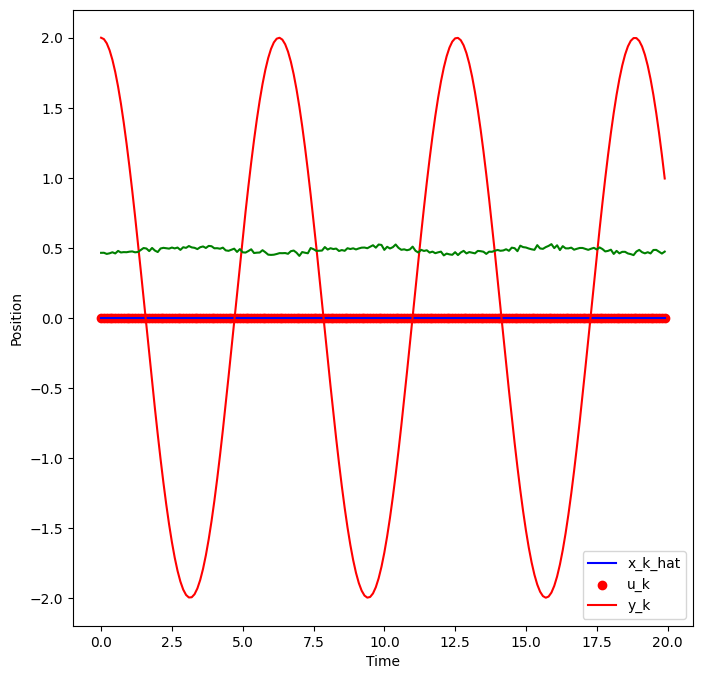

In [97]:
plt.figure(figsize=(8, 8))
plt.plot(t_time[:],x_k_hat[:,0], color='b')
plt.scatter(t_time[:],x_k_check[:,0], color='r') # оценка
plt.plot(t_time[:],u_k, color='r')
plt.plot(t_time[:],y_k, color='g')
plt.xlabel('Time')
plt.ylabel('Position')
plt.legend(['x_k_hat', 'u_k', 'y_k'])
plt.show()